<a href="https://colab.research.google.com/github/YANG-SOBER/EECS-498-598-Deep-Learning-for-Computer-Vision/blob/main/Asgn-4/pytorch_autograd_and_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EECS 498-007/598-005 Assignment 4-1: Pytorch Autograd and NN

Before we start, please put your name and UMID in following format

: Firstname LASTNAME, #00000000   //   e.g.) Justin JOHNSON, #12345678

**Your Answer:**   
Guidong YANG

# [torch.autograd](https://pytorch.org/docs/stable/autograd.html) and [torch.nn](https://pytorch.org/docs/stable/nn.html)

So far, we used PyTorch to accelarate computation using GPU.
PyTorch also provides several useful packages, which help to design deep neural networks efficiently.

The `torch.autograd` package provides classes and functions implementing automatic differentiation of arbitrary scalar valued functions.

This notebook assumes that you are using **PyTorch version 1.3 or above**.
In some of the previous versions (e.g. before 0.4), Tensors had to be wrapped in `torch.autograd.Variable` objects to enable autograd;
however this class has now been deprecated and merged with `torch.Tensor`.
In addition 1.0 also separates a Tensor's datatype from its device, and uses numpy-style factories for constructing Tensors rather than directly invoking Tensor constructors.
Now, to obtain gradients for a tensor via autograd from arbitrary scalar valued functions, you can simply set `requires_grad=True`.

The `torch.nn` package defines a set of Modules, which you can think of as a neural network layer that has produces output from input and may have some trainable weights.

You can also find the detailed [API doc](http://pytorch.org/docs/stable/index.html) here.
If you have other questions that are not addressed by the API docs, the [PyTorch forum](https://discuss.pytorch.org/) is a much better place to ask than StackOverflow.


# Table of Contents

This assignment has 5 parts. You will learn PyTorch on **three different levels of abstraction**, which will help you understand it better.

1. Part I, Preparation: As we always do, we will use CIFAR-10 dataset.
2. Part II, Barebones PyTorch: **Abstraction level 1**, we will work directly with the lowest-level PyTorch Tensors with autograd.
3. Part III, PyTorch Module API: **Abstraction level 2**, we will use `nn.Module` to define an arbitrary neural network architecture. 
4. Part IV, PyTorch Sequential API: **Abstraction level 3**, we will use `nn.Sequential` to define a fully-connected and convolutional network very conveniently. 
5. Part V, Residual Network: please implement your own ResNet to get a high accuracy on CIFAR-10.

Here is a table of comparison:

| API             | Flexibility | Convenience |
|-----------------|-------------|-------------|
| Barebone        | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

# Part I. Preparation

Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
%load_ext autoreload
%autoreload 2

### Google Colab Setup

Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['eecs598', 'network_visualization.py', 'style_transfer.py',  'network_visualization.ipynb', 'a4_helper.py', 'pytorch_autograd_and_nn.py', 'pytorch_autograd_and_nn.ipynb', 'style_transfer.ipynb', 'rnn_lstm_attention_captioning.ipynb',  'rnn_lstm_attention_captioning.py']
```

In [3]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment
# Example: If you create a 2020FA folder and put all the files under A1 folder, then '2020FA/A1'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'A4'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['pytorch_autograd_and_nn.ipynb', 'pytorch_autograd_and_nn.py', 'network_visualization.py', 'style_transfer.py', 'network_visualization.ipynb', 'rnn_lstm_attention_captioning.ipynb', 'rnn_lstm_attention_captioning.py', 'style_transfer.ipynb', 'eecs598', '__pycache__', 'a4_helper.py']


Once you have successfully mounted your Google Drive and located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from pytorch_autograd_and_nn.py!
```

as well as the last edit time for the file `pytorch_autograd_and_nn.py`.

In [4]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

from pytorch_autograd_and_nn import *
from a4_helper import *
hello()

py_path = os.path.join(GOOGLE_DRIVE_PATH, 'pytorch_autograd_and_nn.py')
py_edit_time = time.ctime(os.path.getmtime(py_path))
print('pytorch_autograd_and_nn.py last edited on %s' % py_edit_time)

Hello from pytorch_autograd_and_nn.py!
pytorch_autograd_and_nn.py last edited on Sun Oct 11 23:19:32 2020


### Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from eecs598.utils import reset_seed
from collections import OrderedDict

# for plotting
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%matplotlib inline

We will use the GPU to accelerate our computation. Run this cell to make sure you are using a GPU.

We will be using `torch.float = torch.float32` for data and `torch.long = torch.int64` for labels.

Please refer to https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype for more details about data types.

In [6]:
to_float= torch.float
to_long = torch.long

if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [7]:
import torch

torch.cuda.is_available()

True

### Load CIFAR
Firstly, we will load the CIFAR-10 dataset. The utility function `load_CIFAR()` in `a4_helper` returns training, validaton and testing dataloaders for CIFAR-10 dataset. We are using [torchvision.datasets.CIFAR10](https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=cifar#torchvision.datasets.CIFAR10) to download the CIFAR-10 dataset.

In [8]:
import a4_helper

help(a4_helper.load_CIFAR)

Help on function load_CIFAR in module a4_helper:

load_CIFAR(path='./datasets/')



In [9]:
import torchvision.datasets as dset
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import sampler

In [10]:
def load_CIFAR(path='./datasets/'):

  """
  Download the dataset and iterate it over DataLoader to form minibatches

  Input:
    - path: where to save the dataset
  
  Return:
    - loader_train: DataLoader for training set
    - loader_val: DataLoader for validation set
    - loader_test: DataLoader for test set
  """
  NUM_TRAIN = 49000

  # torchvision.transforms provides tools for preprocessing data and for performing
  # data augmentation
  transform = T.Compose([
                         T.ToTensor(),
                         T.Normalize(
                             mean=(0.4914, 0.4822, 0.4465),
                             std=(0.2023, 0.1994, 0.2010))
                         ])
  cifar10_train = dset.CIFAR10(root=path, train=True, transform=transform, download=True)

  # We divide the CIFAR10 training set into train and val sets by passing a Sampler
  # object to the DataLoader telling how it should sample from the underlying Dataset.
  loader_train = DataLoader(cifar10_train, batch_size=64, 
                            sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))
  
  cifar10_val = dset.CIFAR10(root=path, train=True, transform=transform, download=True)

  loader_val = DataLoader(cifar10_val, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
  
  cifar10_test = dset.CIFAR10(root=path, train=False, transform=transform, download=True)

  loader_test = DataLoader(cifar10_test, batch_size=64)

  return loader_train, loader_val, loader_test

In [11]:
loader_train, loader_val, loader_test = load_CIFAR(path='./datasets/')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./datasets/cifar-10-python.tar.gz to ./datasets/
Files already downloaded and verified
Files already downloaded and verified


In [12]:
type(loader_train), torch.utils.data.DataLoader.__mro__

(torch.utils.data.dataloader.DataLoader,
 (torch.utils.data.dataloader.DataLoader, typing.Generic, object))

In [13]:
for x, y in loader_train:
  print(x.shape, y.shape)
  break

torch.Size([64, 3, 32, 32]) torch.Size([64])


# Part II. Barebones PyTorch

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part II of this tutorial. In this section, we will ***start with the barebone PyTorch elements to understand the autograd engine better***. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple ***fully-connected ReLU network*** with ***two hidden layers and no biases*** for CIFAR classification. 
This implementation ***computes the forward pass using operations on PyTorch Tensors***, and uses ***PyTorch autograd to compute gradients***. It is important that you ***understand every line***, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely, if `x` is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of `x` with respect to the scalar loss at the end.

### Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.

You don't have to write any code here, but it's important that you read and understand the implementation.

In [14]:
to_float = torch.float32
to_long = torch.int64

In [15]:
def two_layer_fc(x, params):
  """
  A fully-connected neural networks; the architecture is:
  NN is fully connected -> ReLU -> fully connected layer.
  Note that this function only defines the forward pass; 
  PyTorch will take care of the backward pass for us.
  
  The input to the network will be a minibatch of data, of shape
  (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
  and the output layer will produce scores for C classes.
  
  Inputs:
  - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
    input data.
  - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
    w1 has shape (H, D) and w2 has shape (C, H).
  
  Returns:
  - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
    the input data x.
  """
  # first we flatten the image
  x = flatten(x)  # shape: [batch_size, C x H x W]
  
  w1, b1, w2, b2 = params
  
  # Forward pass: compute predicted y using operations on Tensors. Since w1 and
  # w2 have requires_grad=True, operations involving these Tensors will cause
  # PyTorch to build a computational graph, allowing automatic computation of
  # gradients. Since we are no longer implementing the backward pass by hand we
  # don't need to keep references to intermediate values.
  # Note that F.linear(x, w, b) is equivalent to x.mm(w.t()) + b
  # For ReLU, you can also use `.clamp(min=0)`, equivalent to `F.relu()`
  x = F.relu(F.linear(x, w1, b1))
  x = F.linear(x, w2, b2)
  return x
    

def two_layer_fc_test():
  hidden_layer_size = 42
  x = torch.zeros((64, 3, 16, 16), dtype=to_float)  # minibatch size 64, feature dimension 3*16*16
  w1 = torch.zeros((hidden_layer_size, 3*16*16), dtype=to_float)
  b1 = torch.zeros((hidden_layer_size,), dtype=to_float)
  w2 = torch.zeros((10, hidden_layer_size), dtype=to_float)
  b2 = torch.zeros((10,), dtype=to_float)
  scores = two_layer_fc(x, [w1, b1, w2, b2])
  print('Output size:', list(scores.size()))  # you should see [64, 10]

two_layer_fc_test()

Output size: [64, 10]


### Barebones PyTorch: Three-Layer ConvNet

Here you will complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like above, we can immediately test our implementation by passing zeros through the network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `kernel_size_1 x kernel_size_1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `kernel_size_2 x kernel_size_2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

Note that we have **no softmax activation** here after our fully-connected layer: this is because PyTorch's cross entropy loss performs a softmax activation for you, and by bundling that step in makes computation more efficient.

**HINT**: For convolutions: https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.conv2d; pay attention to the shapes of convolutional filters! You can use `print(tensor.shape)` for debugging the shapes after each intemidiate layer.

In [16]:
import pytorch_autograd_and_nn

help(pytorch_autograd_and_nn.three_layer_convnet)

Help on function three_layer_convnet in module pytorch_autograd_and_nn:

three_layer_convnet(x, params)
    Performs the forward pass of a three-layer convolutional network with the
    architecture defined above.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, C, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, C, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        fi

In [17]:
import torch.nn.functional as F

In [18]:
def three_layer_convnet(x, params):
  """
  Performs the forward pass of a three-layer convolutional network with the architecture
  defined above.
  """
  conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params

  # conv layer 1
  x = F.relu(F.conv2d(x, conv_w1, conv_b1, stride=1, padding=2))
  # conv layer 2
  x = F.relu(F.conv2d(x, conv_w2, conv_b2, stride=1, padding=1))
  # flatten before final linear layer
  x = x.flatten(start_dim=1)
  # linear layer
  scores = F.linear(x, fc_w, fc_b)

  return scores

Implement `three_layer_convnet` and run the cell below to test it. When you run this function, scores should have shape (64, 10).

In [19]:
def three_layer_convnet_test():
  x = torch.zeros((64, 3, 32, 32), dtype=to_float)  # minibatch size 64, image size [3, 32, 32]

  conv_w1 = torch.zeros((6, 3, 5, 5), dtype=to_float)  # [out_channel, in_channel, kernel_H, kernel_W]
  conv_b1 = torch.zeros((6,))  # out_channel
  conv_w2 = torch.zeros((9, 6, 3, 3), dtype=to_float)  # [out_channel, in_channel, kernel_H, kernel_W]
  conv_b2 = torch.zeros((9,))  # out_channel

  # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
  fc_w = torch.zeros((10, 9 * 32 * 32))
  fc_b = torch.zeros(10)

  # YOUR_TURN: Impelement the three_layer_convnet function
  scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
  print('Output size:', list(scores.size()))  # you should see [64, 10]
three_layer_convnet_test()

Output size: [64, 10]


### Barebones PyTorch: Kaiming Initialization
In this part, we are going to use [Kaiming initialization](https://arxiv.org/abs/1502.01852), which you already implemented in Assignment 3.

Fortunately, PyTorch already provides a function, so we will use this:
[torch.nn.init.kaiming_normal_](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_)

By default, `gain = $\sqrt(2)$`, because this function assumes that ReLU activation follows.
This is true in the linear and convolutional layers in the models you are going to implement, except for the last fully-connected layer:
in principle, we should give `gain = 1` because ReLU is not applied there.
However, as stated in the [original paper](https://arxiv.org/abs/1502.01852), since the factor 1/2 does not matter if it just exists on one layer, we are going to keep using `gain = 2` for simplicity.

For more details on initialization methods provided by PyTorch, see https://pytorch.org/docs/stable/nn.init.html.

In [20]:
torch.nn.init.calculate_gain('relu')

1.4142135623730951

In [21]:
torch.manual_seed(0)

# create a weight of shape [3 x 5]
print(nn.init.kaiming_normal_(torch.empty(3, 5, dtype=to_float, device='cuda')))
print(nn.init.zeros_(torch.empty(3 ,5, dtype=to_float, device='cuda')))

tensor([[-0.5848, -0.2690, -1.6721,  0.0918, -0.0764],
        [-0.3667, -0.3939, -0.2077, -0.6796, -0.2297],
        [-1.0569,  1.4328,  0.1971, -0.1165,  0.8137]], device='cuda:0')
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0')


### Barebones PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [22]:
def check_accuracy_part2(loader, model_fn, params):
  """
  Check the accuracy of a classification model.
  
  Inputs:
  - loader: A DataLoader for the data split we want to check
  - model_fn: A function that performs the forward pass of the model,
    with the signature scores = model_fn(x, params)
  - params: List of PyTorch Tensors giving parameters of the model
  
  Returns: Nothing, but prints the accuracy of the model
  """
  split = 'val' if loader.dataset.train else 'test'
  print('Checking accuracy on the %s set' % split)
  num_correct, num_samples = 0, 0
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device='cuda', dtype=to_float)  # move to device, e.g. GPU
      y = y.to(device='cuda', dtype=to_long)
      scores = model_fn(x, params)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))
    return acc

### BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.nn.functional.cross_entropy` to compute the loss; you can [read about it here](https://pytorch.org/docs/stable/nn.html#crossentropyloss).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [23]:
def train_part2(model_fn, params, learning_rate):

  """
  Train a model on CIFAR-10.

  Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have signature scores = model_fn(x, params), where x is a PyTorch
      Tensor of image data, params is a list of PyTorch Tensors giving model weights,
      and scores is a PyTorch Tensor of shape (N, C) giving scores for the elements
      in x.
    - params: List of PyTorch Tensors giving weights for the model.
    - learnig_rate: Python scalar giving the learning rate to use for SGD.
  
  Returns:
    - acc: validation accuracy
  """
  for t, (x, y) in enumerate(loader_train):

    # Move the data to the corres. devices
    x = x.to(device='cuda', dtype=torch.float32)
    y = y.to(device='cuda', dtype=torch.int64)

    # FORWARD Pass
    scores = model_fn(x, params)

    # BACKWARD Pass
    loss = F.cross_entropy(scores, y)
    loss.backward()

    # Update parameters
    with torch.no_grad():
      for w in params:
        if w.requires_grad:
          w -= learning_rate * w.grad

          # zero out the gradients before next update
          w.grad.zero_()

    if t % 100 == 0 or t == len(loader_train) - 1:
      acc = check_accuracy_part2(loader_val, model_fn, params)
      print("Iteration %d / %d, Loss = %.4f" % (t, len(loader_train), loss))
  return acc



### BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to ***explicitly allocate tensors for the fully connected weights***, `w1` and `w2`. 

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`. 

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the second dimension of `w1`. 
The first dimension of `w1` is the hidden layer size, which will also be the second dimension of `w2`. 

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes. 

You don't need to tune any hyperparameters but you should see accuracies around 40% after training for one epoch.

In [24]:
torch.manual_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2

w1 = torch.nn.init.kaiming_normal_(torch.empty(hidden_layer_size, C*H*W, dtype=torch.float32, device='cuda'))
w1.requires_grad = True
b1 = torch.nn.init.zeros_(torch.empty(hidden_layer_size, dtype=torch.float32, device='cuda'))
b1.requires_grad = True

w2 = torch.nn.init.kaiming_normal_(torch.empty(num_classes, hidden_layer_size, dtype=torch.float32, device='cuda'))
w2.requires_grad = True
b2 = torch.nn.init.zeros_(torch.empty(num_classes, dtype=torch.float32, device='cuda'))
b2.requires_grad = True

acc = train_part2(two_layer_fc, [w1, b1, w2, b2], learning_rate)

Checking accuracy on the val set
Got 148 / 1000 correct (14.80%)
Iteration 0 / 766, Loss = 3.1233
Checking accuracy on the val set
Got 338 / 1000 correct (33.80%)
Iteration 100 / 766, Loss = 2.6943
Checking accuracy on the val set
Got 393 / 1000 correct (39.30%)
Iteration 200 / 766, Loss = 2.1397
Checking accuracy on the val set
Got 397 / 1000 correct (39.70%)
Iteration 300 / 766, Loss = 1.9202
Checking accuracy on the val set
Got 420 / 1000 correct (42.00%)
Iteration 400 / 766, Loss = 1.6580
Checking accuracy on the val set
Got 429 / 1000 correct (42.90%)
Iteration 500 / 766, Loss = 2.1922
Checking accuracy on the val set
Got 424 / 1000 correct (42.40%)
Iteration 600 / 766, Loss = 1.8796
Checking accuracy on the val set
Got 430 / 1000 correct (43.00%)
Iteration 700 / 766, Loss = 1.8559
Checking accuracy on the val set
Got 409 / 1000 correct (40.90%)
Iteration 765 / 766, Loss = 1.5380


### BareBones PyTorch: Training a ConvNet

Now, it's your turn to  implement `initialize_three_layer_conv_part2` function and run the following cell. 

You don't need to tune any hyperparameters, but if everything works correctly you should achieve an accuracy around 45% after one epoch.

In [25]:
def initialize_three_layer_conv_part2(dtype=torch.float32, device='cpu'):
  """
  Initialize weights for the three_layer_convnet for PART II
  Inputs:
    - dtype: A torch data type object;
    - device: device to use for computation. 'cpu' or 'cuda'
  """

  # Input / Output dimensions
  C, H, W = 3, 32, 32
  num_classes = 10

  # Hidden layer channel and kernel sizes
  channel_1 = 32
  channel_2 = 16
  kernel_size_1 = 5
  kernel_size_2 = 3

  # Initialization
  conv_w1 = torch.nn.init.kaiming_normal_(torch.empty(channel_1, C, kernel_size_1, 
                                                      kernel_size_1, dtype=dtype, device=device))
  conv_b1 = torch.nn.init.zeros_(torch.empty(channel_1, dtype=dtype, device=device))

  conv_w2 = torch.nn.init.kaiming_normal_(torch.empty(channel_2, channel_1, kernel_size_2,
                                                      kernel_size_2, dtype=dtype, device=device))
  conv_b2 = torch.nn.init.zeros_(torch.empty(channel_2, dtype=dtype, device=device))

  fc_w = torch.nn.init.kaiming_normal_(torch.empty(num_classes, channel_2*H*W, dtype=dtype,
                                                   device=device))
  fc_b = torch.nn.init.zeros_(torch.empty(num_classes, dtype=dtype, device=device))

  params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]

  for param in params:
    param.requires_grad = True
  
  return params

In [26]:
torch.manual_seed(0)
learning_rate = 3e-3
# YOUR_TURN: Impelement the initialize_three_layer_conv_part2 function
params = initialize_three_layer_conv_part2(dtype=to_float, device='cuda')
acc_hist_part2 = train_part2(three_layer_convnet, params, learning_rate)

Checking accuracy on the val set
Got 114 / 1000 correct (11.40%)
Iteration 0 / 766, Loss = 2.4541
Checking accuracy on the val set
Got 334 / 1000 correct (33.40%)
Iteration 100 / 766, Loss = 1.9128
Checking accuracy on the val set
Got 383 / 1000 correct (38.30%)
Iteration 200 / 766, Loss = 1.8493
Checking accuracy on the val set
Got 415 / 1000 correct (41.50%)
Iteration 300 / 766, Loss = 1.6154
Checking accuracy on the val set
Got 430 / 1000 correct (43.00%)
Iteration 400 / 766, Loss = 1.5129
Checking accuracy on the val set
Got 455 / 1000 correct (45.50%)
Iteration 500 / 766, Loss = 1.7212
Checking accuracy on the val set
Got 477 / 1000 correct (47.70%)
Iteration 600 / 766, Loss = 1.6025
Checking accuracy on the val set
Got 475 / 1000 correct (47.50%)
Iteration 700 / 766, Loss = 1.7568
Checking accuracy on the val set
Got 480 / 1000 correct (48.00%)
Iteration 765 / 766, Loss = 1.2916


# Part III. PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to ***define arbitrary network architectures, while tracking every learnable parameters for you***. In Part II, we implemented SGD ourselves. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as ***RMSProp, Adagrad, and Adam***. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

***My own summary***:

**1) Barebone PyTorch**

For Barebone PyTorch, when we define neural network architecture, we use `torch.nn.functional.conv2d` or `torch.nn.functional.linear`. In this case, we need to explicitly define and initialize learnable parameters for convolutional layer and linear layer. And then we pass the initialized learnable parameters into the network, after which we conduct forward pass, compute loss, conduct backward pass to automatically compute gradients via `torch.autograd`. Finally, we manually (and iteratively) conduct gradient descent explicitly and zero out the gradients.

The ***disadvantage*** of Barebone PyTorch is that, we track all the parameter tensors by hand. This is fine for ***small networks*** with a few tensors, but it would be ***extremely inconvenient and error-prone*** to track tens or hundreds of tensors in large networks.

**2) PyTorch Module API**

For PyTorch Module API, PyTorch provides `nn.Module` for us to define ***arbitrary neural network architectures***, while ***tracking every learnable parameters for us***. PyTorch also provides `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. It even supports approximate second-order methods like L-BFGS! 

Also, the `torch.optim.lr_scheduler` implements all the common learning rate schedule methods.

### Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network.
We use `nn.init.kaiming_normal_` to initialize weights using Kaiming initialization, and `nn.init.zeros_` to initialize biases.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`, give your network class an intuitive nale like TwoLayerFC.

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` ***subclasses*** and contain learnable parameters, ***so that you don't have to instantiate the raw tensors yourself***. `nn.Module` will track these internal parameters for you. 

In [27]:
class TwoLayerFC(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()

    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, num_classes)

    nn.init.kaiming_normal_(self.fc1.weight)
    nn.init.zeros_(self.fc1.bias)
    nn.init.kaiming_normal_(self.fc2.weight)
    nn.init.zeros_(self.fc2.bias)
  
  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    scores = self.fc2(x)

    return scores


In [28]:
def test_TwoLayerFC():
  input_size = 3*16*16
  x = torch.zeros((64, input_size), dtype=to_float)  # minibatch size 64, feature dimension 3*16*16
  model = TwoLayerFC(input_size, 42, 10)
  scores = model(x)
  print('Architecture:')
  print(model) # printing `nn.Module` shows the architecture of the module.
  print('Output size:', list(scores.size()))  # you should see [64, 10]
test_TwoLayerFC()

Architecture:
TwoLayerFC(
  (fc1): Linear(in_features=768, out_features=42, bias=True)
  (fc2): Linear(in_features=42, out_features=10, bias=True)
)
Output size: [64, 10]


### Module API: Three-Layer ConvNet
It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. 

After you implement the `ThreeLayerConvNet`, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [29]:
class ThreeLayerConvNet(nn.Module):
  def __init__(self, in_channel, channel_1, channel_2, num_classes):
    super().__init__()

    # Define all layers
    self.conv1 = nn.Conv2d(in_channel, channel_1, kernel_size=5, stride=1, padding=2) # maintain spatial size
    self.conv2 = nn.Conv2d(channel_1, channel_2, kernel_size=3, stride=1, padding=1) # maintain spatial size
    self.fc = nn.Linear(channel_2*32*32, num_classes)

    # Initialize the weights and biases
    nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
    nn.init.zeros_(self.conv1.bias)
    nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
    nn.init.zeros_(self.conv2.bias)
  
  def forward(self, x):
    # Define the connectivity of the network
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x)) # (N, C, H, W)
    x = x.flatten(start_dim=1) # (N, C*H*W)
    scores = self.fc(x)

    return scores

In [30]:
def test_ThreeLayerConvNet():
  x = torch.zeros((64, 3, 32, 32), dtype=to_float)  # minibatch size 64, image size [3, 32, 32]
  # YOUR_TURN: Impelement the functions in ThreeLayerConvNet class
  model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
  scores = model(x)
  print(model) # printing `nn.Module` shows the architecture of the module.
  print('Output size:', list(scores.size()))  # you should see [64, 10]
test_ThreeLayerConvNet()

ThreeLayerConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(12, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=8192, out_features=10, bias=True)
)
Output size: [64, 10]


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [31]:
def check_accuracy_part34(loader, model):
  if loader.dataset.train:
    print('Checking accuracy on validation set')
  else:
    print('Checking accuracy on test set')   
  num_correct = 0
  num_samples = 0
  model.eval()  # set model to evaluation mode
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device='cuda', dtype=to_float)  # move to device, e.g. GPU
      y = y.to(device='cuda', dtype=to_long)
      scores = model(x)
      _, preds = scores.max(1)
      num_correct += (preds == y).sum()
      num_samples += preds.size(0)
    acc = float(num_correct) / num_samples
    print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
  return acc

In [32]:
model = ThreeLayerConvNet(3, 32, 16, 10)
type(model.parameters())

generator

In [33]:
my_optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
my_optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [34]:
my_optimizer.param_groups[0]['eps']

1e-08

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [35]:
def adjust_learning_rate(optimizer, lrd, epoch, schedule):
  """
  Multiply lrd to the learning rate if epoch is in schedule

  Inputs:
  - optimizer: An Optimizer object we will use to train the model.
  - lrd: learning rate decay; a factor multiplied at scheduled epochs.
  - epochs: the current epoch number
  - schedule: the list of epochs that requires learning rate update.
  """
  if epoch in schedule:
    for param_group in optimizer.param_groups:
      print("Decay the learning rate from {} to {}".format(param_group['lr'], param_group['lr']*lrd))
      param_group['lr'] *= lrd

In [36]:
def train_part345(model, optimizer, epochs=1, learning_rate_decay=0.1, schedule=[], verbose=True):
  """
  Train a model on CIFAR-10 using the PyTorch Module API

  Inputs:
  - model: A PyTorch Module giving the model to train.
  - optimizer: An Optimizer object we will use to train the model.
  - epochs: (Optional) A Python integer giving the number of epochs to train for

  Returns: nothing, but prints model accuracies during training.
  """

  # Move the model parameters to the corresponding devices before defining the optimizer
  model = model.to(device='cuda')

  num_iterations = epochs * len(loader_train)
  print_every = 100

  if verbose:
    num_prints = num_iterations // print_every + 1
  else:
    num_prints = epochs 
  
  acc_history = torch.zeros(num_prints, dtype=torch.float32)
  iter_history = torch.zeros(num_prints, dtype=torch.int64)
  
  for epoch in range(epochs):

    adjust_learning_rate(optimizer, learning_rate_decay, epoch, schedule)

    for t, (x, y) in enumerate(loader_train):

      # Put the model in training mode
      # because we set the model in eval mode in `check_accuracy_part3d`
      model.train()

      # Move the data to the corresponding devices
      x = x.to(device='cuda', dtype=torch.float32)
      y = y.to(device='cuda', dtype=torch.int64)

      # Forward pass
      scores = model(x)
      loss = F.cross_entropy(scores, y)

      # Backward pass and Update parameters
      # Zero out all the gradients for the variables which the optimizer will update
      optimizer.zero_grad()

      # Compute the gradients of the loss w.r.t each parameter of the model.
      loss.backward()

      # Actually update the parameters of the model using the gradients computed by
      # the backward pass
      optimizer.step()

      # record current number of iterations
      tt = t + epoch * len(loader_train)

      # some print setting
      if verbose and ((tt % print_every == 0) or (epoch == epochs-1 and t == len(loader_train) - 1)):
        print("Epoch %d, Iteration %d, Loss = %.4f" % (epoch, tt, loss))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[tt // print_every] = acc
        iter_history[tt // print_every] = tt
        print()
      
      elif not verbose and (t == len(loader_train) - 1):
        print("Epoch %d, Iteration %d, Loss = %.4f" % (epoch, tt, loss))
        acc = check_accuracy_part34(loader_val, model)
        acc_history[epoch] = acc
        iter_history[epoch] = tt
        print()
  return acc_history, iter_history

### Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part II, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`. 

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

You don't need to tune any hyperparameters or implement anything, but you should see model accuracies around 40% after training for one epoch.

In [37]:
torch.manual_seed(0)

C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2
weight_decay = 1e-4

model = TwoLayerFC(C*H*W, hidden_layer_size, num_classes)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

_ = train_part345(model, optimizer)

Epoch 0, Iteration 0, Loss = 3.3988
Checking accuracy on validation set
Got 139 / 1000 correct (13.90)

Epoch 0, Iteration 100, Loss = 2.9726
Checking accuracy on validation set
Got 328 / 1000 correct (32.80)

Epoch 0, Iteration 200, Loss = 2.1088
Checking accuracy on validation set
Got 335 / 1000 correct (33.50)

Epoch 0, Iteration 300, Loss = 2.1712
Checking accuracy on validation set
Got 432 / 1000 correct (43.20)

Epoch 0, Iteration 400, Loss = 1.9799
Checking accuracy on validation set
Got 433 / 1000 correct (43.30)

Epoch 0, Iteration 500, Loss = 1.7887
Checking accuracy on validation set
Got 445 / 1000 correct (44.50)

Epoch 0, Iteration 600, Loss = 2.0996
Checking accuracy on validation set
Got 473 / 1000 correct (47.30)

Epoch 0, Iteration 700, Loss = 1.6745
Checking accuracy on validation set
Got 472 / 1000 correct (47.20)

Epoch 0, Iteration 765, Loss = 1.6808
Checking accuracy on validation set
Got 410 / 1000 correct (41.00)



### Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network! You don't need to tune any hyperparameters, but you should achieve above around 45% after training for one epoch.

Implement the `initialize_three_layer_conv_part3` function, you should train the model using stochastic gradient descent without momentum, with L2 weight decay of 1e-4.

In [38]:
def initialize_three_layer_conv_part3():
  """
  Instantiate a ThreeLayerConvNet model and a corresponding optimizer for part III
  """

  # Parameters for ThreeLayerConvNet
  C = 3
  num_classes = 10

  channel_1 = 32
  channel_2 = 16

  # Parameters for optimizer
  learning_rate = 3e-3
  weight_decay = 1e-4

  model = ThreeLayerConvNet(C, channel_1, channel_2, num_classes)
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


  return model, optimizer

In [39]:
torch.manual_seed(0)
# YOUR_TURN: Impelement initialize_three_layer_conv_part3
model, optimizer = initialize_three_layer_conv_part3()
acc_hist_part3, _ = train_part345(model, optimizer)

Epoch 0, Iteration 0, Loss = 2.5484
Checking accuracy on validation set
Got 121 / 1000 correct (12.10)

Epoch 0, Iteration 100, Loss = 1.7905
Checking accuracy on validation set
Got 365 / 1000 correct (36.50)

Epoch 0, Iteration 200, Loss = 1.8050
Checking accuracy on validation set
Got 447 / 1000 correct (44.70)

Epoch 0, Iteration 300, Loss = 1.6710
Checking accuracy on validation set
Got 448 / 1000 correct (44.80)

Epoch 0, Iteration 400, Loss = 1.5466
Checking accuracy on validation set
Got 481 / 1000 correct (48.10)

Epoch 0, Iteration 500, Loss = 1.6006
Checking accuracy on validation set
Got 506 / 1000 correct (50.60)

Epoch 0, Iteration 600, Loss = 1.3884
Checking accuracy on validation set
Got 508 / 1000 correct (50.80)

Epoch 0, Iteration 700, Loss = 1.2571
Checking accuracy on validation set
Got 519 / 1000 correct (51.90)

Epoch 0, Iteration 765, Loss = 1.1433
Checking accuracy on validation set
Got 496 / 1000 correct (49.60)



# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Sequential API: Two-Layer Network
Let's see how to rewrite our two-layer fully connected network example with `nn.Sequential`, and train it using the training loop defined above.
Here, let's skip weight initialization for simplicity;
with a more advanced optimizer than the naive SGD, the default initialization provided in `torch.nn` is good enough for shallow networks.

Again, you don't need to tune any hyperparameters or implement anything here, but you should achieve around 40% accuracy after one epoch of training.

In [40]:
torch.manual_seed(0)
C, H, W = 3, 32, 32
num_classes = 10

hidden_layer_size = 4000
learning_rate = 1e-2
weight_decay = 1e-4
momentum = 0.5

# To give a specific name to each module, use OrderedDict.
model = nn.Sequential(OrderedDict([
  ('flatten', Flatten()),
  ('fc1', nn.Linear(C*H*W, hidden_layer_size)),
  ('relu1', nn.ReLU()),
  ('fc2', nn.Linear(hidden_layer_size, num_classes)),
]))

print('Architecture:')
print(model) # printing `nn.Module` shows the architecture of the module.

# you can use Nesterov momentum in optim.SGD
optimizer = optim.SGD(model.parameters(), lr=learning_rate, 
                      weight_decay=weight_decay,
                      momentum=momentum, nesterov=True)

_ = train_part345(model, optimizer)

Architecture:
Sequential(
  (flatten): Flatten()
  (fc1): Linear(in_features=3072, out_features=4000, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=4000, out_features=10, bias=True)
)
Epoch 0, Iteration 0, Loss = 2.3772
Checking accuracy on validation set
Got 137 / 1000 correct (13.70)

Epoch 0, Iteration 100, Loss = 1.7475
Checking accuracy on validation set
Got 394 / 1000 correct (39.40)

Epoch 0, Iteration 200, Loss = 1.7008
Checking accuracy on validation set
Got 408 / 1000 correct (40.80)

Epoch 0, Iteration 300, Loss = 1.6135
Checking accuracy on validation set
Got 444 / 1000 correct (44.40)

Epoch 0, Iteration 400, Loss = 1.6344
Checking accuracy on validation set
Got 452 / 1000 correct (45.20)

Epoch 0, Iteration 500, Loss = 1.5482
Checking accuracy on validation set
Got 462 / 1000 correct (46.20)

Epoch 0, Iteration 600, Loss = 1.4813
Checking accuracy on validation set
Got 470 / 1000 correct (47.00)

Epoch 0, Iteration 700, Loss = 1.6609
Checking accuracy on valida

### Sequential API: Three-Layer ConvNet
Now, it's your turn to use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III. 

Implement `initialize_three_layer_conv_part4` and  you should see accuracy around 50% after one epoch of training.                      
	

In [41]:
test_dict = OrderedDict()

test_dict['b'] = 3
test_dict['a'] = 6
test_dict['d'] = 1

for key, value in test_dict.items():
  print(key, value)

b 3
a 6
d 1


In [42]:
test_dict

OrderedDict([('b', 3), ('a', 6), ('d', 1)])

In [43]:
def initialize_three_layer_conv_part4():
  """
  Instantiate a ThreeLayerConvNet model and a corresponding optimizer for part IV
  """

  # Input / Output dimensions
  C, H, W = 3, 32, 32
  num_classes = 10

  # Hidden layer channel and kernel sizes
  channel_1 = 32
  channel_2 = 16
  kernel_size_1 = 5
  pad_size_1 = 2
  kernel_size_2 = 3
  pad_size_2 = 1

  # Parameters for optimizer
  learning_rate = 1e-2
  weight_decay = 1e-4
  momentum=0.5

  # Define model via nn.Sequential
  model = nn.Sequential(OrderedDict(
      [
       ('conv1', nn.Conv2d(C, channel_1, kernel_size_1, stride=1, padding=pad_size_1)),
       ('relu1', nn.ReLU()),
       ('conv2', nn.Conv2d(channel_1, channel_2, kernel_size_2, stride=1, padding=pad_size_2)),
       ('relu2', nn.ReLU()),
       ('flatten', nn.Flatten(start_dim=1)),
       ('fc', nn.Linear(channel_2*H*W, num_classes))
      ]
  ))

  optimizer = optim.SGD(model.parameters(), learning_rate, momentum, weight_decay=weight_decay, nesterov=True)

  return model, optimizer

In [44]:
torch.manual_seed(0)

# YOUR_TURN: Impelement initialize_three_layer_conv_part4
model, optimizer = initialize_three_layer_conv_part4()
print('Architecture:')
print(model) # printing `nn.Module` shows the architecture of the module.

acc_hist_part4, _ = train_part345(model, optimizer)

Architecture:
Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (conv2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=16384, out_features=10, bias=True)
)
Epoch 0, Iteration 0, Loss = 2.2960
Checking accuracy on validation set
Got 136 / 1000 correct (13.60)

Epoch 0, Iteration 100, Loss = 1.6672
Checking accuracy on validation set
Got 382 / 1000 correct (38.20)

Epoch 0, Iteration 200, Loss = 1.4602
Checking accuracy on validation set
Got 479 / 1000 correct (47.90)

Epoch 0, Iteration 300, Loss = 1.7120
Checking accuracy on validation set
Got 480 / 1000 correct (48.00)

Epoch 0, Iteration 400, Loss = 1.6092
Checking accuracy on validation set
Got 490 / 1000 correct (49.00)

Epoch 0, Iteration 500, Loss = 1.4300
Checking accuracy on validation set
Got 499 / 1000 correct (49.90)

Epoch 0, Iteration 600, Loss = 1.5045
Che

In [45]:
# Input / Output dimensions
C, H, W = 3, 32, 32
num_classes = 10

# Hidden layer channel and kernel sizes
channel_1 = 32
channel_2 = 16
kernel_size_1 = 5
pad_size_1 = 2
kernel_size_2 = 3
pad_size_2 = 1

model = nn.Sequential(
      nn.Conv2d(C, channel_1, kernel_size_1, stride=1, padding=pad_size_1),
      nn.ReLU(),
      nn.Conv2d(channel_1, channel_2, kernel_size_2, stride=1, padding=pad_size_2),
      nn.ReLU(),
      nn.Flatten(),
      nn.Linear(channel_2*H*W, num_classes))
print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=16384, out_features=10, bias=True)
)


# Part V. ResNet for CIFAR-10

In this section, you are going to implement [ResNet](https://arxiv.org/abs/1512.03385), one of the state-of-the-art CNN architecture.
Specifically, you are going to implement a variation of ResNet called [PreResNet](https://arxiv.org/abs/1603.05027), which locates activation before each convolutional layer (so called pre-activation).
You are going to first implement a plain building block, residual block, and then bottleneck block for really deep networks.
Finally, you will implement your own ResNet using those blocks.

Throughout this part, we will follow the PyTorch default weight initialization for conciseness.

## Plain block

First, let's implement a ***plain block*** **without residual connection**.
PreResNet has a different order of layers from the previously implemented ones;
BatchNorm and ReLU precedes Conv.
The name of PreResNet comes form this pre-activation architecture.
Here, for ***downsampling***, we don't introduce MaxPool layers explicitly, but use stride 2 in the first Conv layer in the block.

Concretely, a plain block accepts a feature map of shape $C_{in} \times H_{in} \times W_{out}$ and produces a feature map of shape $C_{out} \times H_{out} \times W_{out}$. If the block performs downsampling, then $W_{out}=W_{in}/2$ and $H_{out}=H_{in}/2$; otherwise $H_{out}=H_{in}$ and $W_{out}=W_{in}$. The plain block consists of the following six layers in order:

1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout` 3x3 filters, zero-padding of 1, and stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout` 3x3 filters, with zero-padding of 1

Implement the `PlainBlock.__init__` function and run the following cell. You should see a message indicating that your implementation is correct.


In [88]:
class PlainBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.net = nn.Sequential(OrderedDict(
        [
         ('BN_1', nn.BatchNorm2d(Cin)),
         ('relu_1', nn.ReLU()),
         ('conv_1', nn.Conv2d(Cin, Cout, kernel_size=3, stride=2 if downsample else 1, padding=1)),
         ('BN_2', nn.BatchNorm2d(Cout)),
         ('relu_2', nn.ReLU()),
         ('conv_2', nn.Conv2d(Cout, Cout, kernel_size=3, stride=1, padding=1))
        ]
    ))

  def forward(self, x):
    return self.net(x)

In [47]:
downsample = False
nn.Conv2d(3, 16, 3, stride=2 if downsample else 1)

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [49]:
data = torch.zeros(2, 3, 5, 6)
# YOUR_TURN: Impelement PlainBlock.__init__
model = PlainBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of PlainBlock without downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
# YOUR_TURN: Impelement PlainBlock.__init__
model = PlainBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of PlainBlock with downsampling has a *correct* dimension!')
else:
  print('The output of PlainBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of PlainBlock without downsampling has a *correct* dimension!
The output of PlainBlock with downsampling has a *correct* dimension!


In [51]:
list(model(data).shape)

[2, 10, 3, 3]

## Residual block

Next, let's implement a residual block.
***A residual block adds a residual connection to a plain block***. Let $\mathcal{F}$ be a plain block; then the residual version  $\mathcal{R}$ of the plain block $\mathcal{F}$ computes:

$\mathcal{R}(x) = \mathcal{F}(x) + x$

However, this implementation will ***only work if the output from the plain block $\mathcal{F}(x)$ has the same shape as the input $x$***. Based on the plain block that we implemented above, there are two cases where the output of the plain block can have a different shape than the input:

1. The number of output channels $C_{out}$ is different from the number of input channels $C_{in}$
2. The plain block $\mathcal{F}$ performs spatial downsampling

To deal with these cases, we need generalize our definition of the residual block and add a *shortcut connection* $\mathcal{G}$:

$\mathcal{R}(x) = \mathcal{F}(x) + \mathcal{G}(x)$

There are three cases for the shortcut connection $\mathcal{G}$:

1. If $C_{in}=C_{out}$ and $\mathcal{F}$ does not perform downsampling, then $\mathcal{F}(x)$ will have the same shape as $x$, so $\mathcal{G}$ is the identity function: $\mathcal{G}(x) = x$
2. If $C_{in} \neq C_{out}$ and $\mathcal{F}$ does not downsample, then $\mathcal{G}$ is a 1x1 convolution with $C_{out}$ filters and stride 1.
3. If $\mathcal{F}$ downsamples, then $\mathcal{G}$ is a 1x1 convolution with $C_{out}$ filters and stride 2.

Implement the `ResidualBlock.__init__` function and run the following cell. You should see a message indicating that your implementation is correct.

In [54]:
class ResidualBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.block = PlainBlock(Cin, Cout, downsample) # F
    if Cin == Cout and not downsample:
      self.shortcut = nn.Identity()
    elif Cin != Cout and not downsample:
      self.shortcut = nn.Conv2d(Cin, Cout, kernel_size=1, stride=1)
    elif downsample:
      self.shortcut = nn.Conv2d(Cin, Cout, kernel_size=1, stride=2)
    
  def forward(self, x):
    return self.block(x) + self.shortcut(x)

In [55]:
data = torch.zeros(2, 3, 5, 6)
# YOUR_TURN: Impelement ResidualBlock.__init__
model = ResidualBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
# YOUR_TURN: Impelement ResidualBlock.__init__
model = ResidualBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


In [60]:
class ResNetStage(nn.Module):
  def __init__(self, Cin, Cout, num_blocks, downsample=True,
               block=ResidualBlock):
    super().__init__()

    blocks = [block(Cin, Cout, downsample)]
    for i in range(num_blocks - 1):
      blocks.append(block(Cout, Cout))
    self.net = nn.Sequential(*blocks)

  def forward(self, x):
    return self.net(x)

## Residual stage

So far, you implemented micro layers, which consists of several convolutional layers.
To efficiently build a deep neural network, we define a macro layer by repeating the micro layers.

For your convenience, we provide the implementation in `pytorch_autograd_and_nn.py`.

```
class ResNetStage(nn.Module):
  def __init__(self, Cin, Cout, num_blocks, downsample=True,
               block=ResidualBlock):
    super().__init__()
    blocks = [block(Cin, Cout, downsample)]
    for _ in range(num_blocks - 1):
      blocks.append(block(Cout, Cout))
    self.net = nn.Sequential(*blocks)
  
  def forward(self, x):
    return self.net(x)
```




In [61]:
print('Plain block stage:')
print(ResNetStage(3, 4, 2, block=PlainBlock))
print('Residual block stage:')
print(ResNetStage(3, 4, 2, block=ResidualBlock))

Plain block stage:
ResNetStage(
  (net): Sequential(
    (0): PlainBlock(
      (net): Sequential(
        (BN_1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_1): ReLU()
        (conv_1): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (BN_2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_2): ReLU()
        (conv_2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
    (1): PlainBlock(
      (net): Sequential(
        (BN_1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_1): ReLU()
        (conv_1): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (BN_2): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_2): ReLU()
        (conv_2): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
)
Residual bloc

In [62]:
class ResNetStem(nn.Module):
  def __init__(self, Cin, Cout):
    super().__init__()
    layers = [
              nn.Conv2d(Cin, Cout, kernel_size=1, stride=1),
              nn.ReLU()
    ]
    self.net = nn.Sequential(*layers)
  
  def forward(self, x):
    return self.net(x)

## Residual stem

A "stem" layer is required at the beginning of the network, which ***increases the number of channels while keeping the other dimensions***.

For your convenience, we provide the implementation in `pytorch_autograd_and_nn.py`.



```
class ResNetStem(nn.Module):
  def __init__(self, Cin=3, Cout=8):
    super().__init__()
    layers = [
        nn.Conv2d(Cin, Cout, kernel_size=3, padding=1, stride=1),
        nn.ReLU(),
    ]
    self.net = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.net(x)
```



In [63]:
data = torch.zeros(2, 3, 5, 6)
model = ResNetStem(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResNetStem without downsampling has a *correct* dimension!')
else:
  print('The output of ResNetStem without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

The output of ResNetStem without downsampling has a *correct* dimension!


## ResNet class

Now, it is time to design the ResNet class using the blocks you implemented above!

For general applicability, the class will get a dictionary of the architecture specification as an input, and parse it to build a CNN.

Here we provide a couple of examples of specification;
`networks` is a collection of pre-defined network specifications, where each can be called by `get_resnet(key)`, where key is the name of the network, e.g., `get_resnet('resnet32')` will return a ResNet with 32 layers.

Each specification consists of multiple tuples which correspond to a macro block (`ResNetStage`), and the values in each tuple implies `(num_in_channels, num_out_channels, num_blocks, do_downsample)`.

To avoid dependency on the size of the input, ResNet has an average pooling at the end of the convolutional part, such that the size of the input tensor to the linear layer is always `(batch_size, stage_args[-1][1])`.
You may want to add an average pooling layer (`nn.AvgPool2d`), but it requires to know the size of the input.
Can you relax this requirement?

**Hint**: You can perform average pooling in `forward`.

Implement `ResNet.__init__` and `ResNet.forward` and train it on CIFAR.

In [98]:
class ResNet(nn.Module):
  def __init__(self, stage_args, Cin=3, block=ResidualBlock, num_classes=10):
    super().__init__()
    stages = [ResNetStem(Cin, stage_args[0][0])]
    for stage_arg in stage_args:
      stages.append(
          ResNetStage(stage_arg[0], stage_arg[1], stage_arg[2], stage_arg[3],
                      block)
      )
    self.cnn = nn.Sequential(*stages)
    self.fc = nn.Linear(stage_args[-1][1], num_classes)
  
  def forward(self, x):
    
    x = self.cnn(x)
    x = F.avg_pool2d(x, kernel_size=tuple(x.shape[-2:]), stride=1)
    x = x.flatten(start_dim=1)
    scores = self.fc(x)

    return scores

In [99]:
# example of specifications
networks = {
  'plain32': {
    'block': PlainBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
  'resnet32': {
    'block': ResidualBlock,
    'stage_args': [
      (8, 8, 5, False),
      (8, 16, 5, True),
      (16, 32, 5, True),
    ]
  },
}

def get_resnet(name):
  # YOUR_TURN: Impelement ResNet.__init__ and ResNet.forward
  return ResNet(**networks[name])

## Train your model!

Now let's train a few epochs of plain and residual networks with 32 layers on CIFAR.
You will see that deep non-residual networks don't converge well.

**Caution: This takes a long time!**

**Disclaimer: The performance of PreResNet-32 you will see here (~ 80%) would be lower than the best performance this model can achieve, because the convergence requires much more training.**

In [100]:
names = ['plain32', 'resnet32']
acc_history_dict = {}
iter_history_dict = {}
for name in names:
  reset_seed(0)
  print(name, '\n')
  model = get_resnet(name)
#   init_module(model)
  print(model)
  
  optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=.9, weight_decay=1e-4)

  acc_history, iter_history = train_part345(model, optimizer, epochs=10, schedule=[6, 8], verbose=False)
  acc_history_dict[name] = acc_history
  iter_history_dict[name] = iter_history

plain32 

ResNet(
  (cnn): Sequential(
    (0): ResNetStem(
      (net): Sequential(
        (0): Conv2d(3, 8, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
    )
    (1): ResNetStage(
      (net): Sequential(
        (0): PlainBlock(
          (net): Sequential(
            (BN_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu_1): ReLU()
            (conv_1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (BN_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu_2): ReLU()
            (conv_2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (1): PlainBlock(
          (net): Sequential(
            (BN_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu_1): ReLU()
            (conv_1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

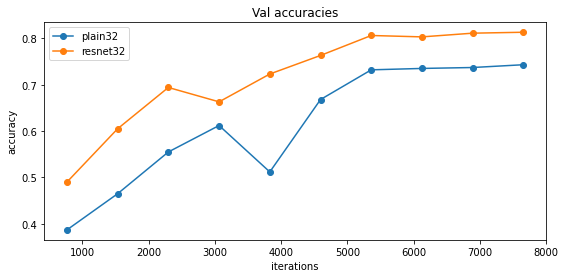

In [101]:
plt.title('Val accuracies')
for name in names:
  plt.plot(iter_history_dict[name], acc_history_dict[name], '-o')
plt.legend(names, loc='upper left')
plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.gcf().set_size_inches(9, 4)
plt.show()

## Residual bottleneck block

A bottleneck block is often useful for better efficiency, especially when importing a model to mobile devices.
The residual bottleneck block is similar to the standard residual block, but the plain block part has a different architecture:
it consists of 3 convolutional layers, and the first two convolutional layers have a smaller number of channels.

Here is the specification of the bottleneck block:

1. Spatial Batch normalization
2. ReLU
3. Convolutional layer with `Cout // 4` 1x1 filters, stride 2 if downsampling; otherwise stride 1
4. Spatial Batch normalization
5. ReLU
6. Convolutional layer with `Cout // 4` 3x3 filters, with zero-padding of 1
7. Spatial Batch normalization
8. ReLU
9. Convolutional layer with `Cout` 1x1 filters

Implement `ResidualBottleneckBlock.__init__` and don't forget to add the residual connection!

In [102]:
class ResidualBottleneckBlock(nn.Module):
  def __init__(self, Cin, Cout, downsample=False):
    super().__init__()

    self.block = nn.Sequential(OrderedDict(
        [
         ('Spatial_BN_1', nn.BatchNorm2d(Cin)),
         ('ReLU_1', nn.ReLU()),
         ('Conv_1', nn.Conv2d(Cin, Cout//4, kernel_size=1, stride=2 if downsample else 1)),
         ('Spatial_BN_2', nn.BatchNorm2d(Cout//4)),
         ('ReLU_2', nn.ReLU()),
         ('Conv_2', nn.Conv2d(Cout//4, Cout//4, kernel_size=3, stride=1, padding=1)),
         ('Spatial_BN_3', nn.BatchNorm2d(Cout//4)),
         ('ReLU_2', nn.ReLU()),
         ('Conv_3', nn.Conv2d(Cout//4, Cout, kernel_size=1))
        ]
    ))

    if Cin == Cout and not downsample:
      self.shortcut = nn.Identity()
    elif Cin != Cout and not downsample:
      self.shortcut = nn.Conv2d(Cin, Cout, kernel_size=1, stride=1)
    elif downsample:
      self.shortcut = nn.Conv2d(Cin, Cout, kernel_size=1, stride=2)

  def forward(self, x):
    return self.block(x) + self.shortcut(x)

In [103]:
data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10)
if list(model(data).shape) == [2, 10, 5, 6]:
  print('The output of ResidualBlock without downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock without downsampling has an *incorrect* dimension! expected:', [2, 10, 5, 6], 'got:', list(model(data).shape))

data = torch.zeros(2, 3, 5, 6)
model = ResidualBottleneckBlock(3, 10, downsample=True)
if list(model(data).shape) == [2, 10, 3, 3]:
  print('The output of ResidualBlock with downsampling has a *correct* dimension!')
else:
  print('The output of ResidualBlock with downsampling has an *incorrect* dimension! expected:', [2, 10, 3, 3], 'got:', list(model(data).shape))

The output of ResidualBlock without downsampling has a *correct* dimension!
The output of ResidualBlock with downsampling has a *correct* dimension!


By running the following script, you can check the architecture of ResNet-47 with bottlenecks.

Caution: it is long!

In [105]:
# example of specification
networks.update({
  'resnet47': {
    'block': ResidualBottleneckBlock,
    'stage_args': [
      (32, 32, 5, False),
      (32, 64, 5, True),
      (64, 128, 5, True),
    ],
  },
})

print(get_resnet('resnet47'))

ResNet(
  (cnn): Sequential(
    (0): ResNetStem(
      (net): Sequential(
        (0): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
    )
    (1): ResNetStage(
      (net): Sequential(
        (0): ResidualBottleneckBlock(
          (block): Sequential(
            (Spatial_BN_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (ReLU_1): ReLU()
            (Conv_1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (Spatial_BN_2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (ReLU_2): ReLU()
            (Conv_2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (Spatial_BN_3): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (Conv_3): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          )
          (shortcut): Identity()
        )
        (1): ResidualBottleneckBlock(
          (b

# Final checks
Make sure you run "Runtime -> Restart and run all..." to double check PyTorch Autograd and NN before submitting.

# Save results

Once all the cells are completed, save the loss history of all the parts for submission.

In [ ]:
acc_history_dict['acc_hist_part2'] = acc_hist_part2 
acc_history_dict['acc_hist_part3'] = acc_hist_part3 
acc_history_dict['acc_hist_part4'] = acc_hist_part4 
submission_path = os.path.join(GOOGLE_DRIVE_PATH, 'pytorch_autograd_and_nn.pkl')
dump_results(acc_history_dict, submission_path)